1. 배경
본 대회는 다음을 목표로 합니다.

전력 수요 예측 시뮬레이션을 통한 효율적인 인공지능 알고리즘 발굴
전력 융합 신서비스 발굴 및 비즈니스 모델 개발 활용
디지털 뉴딜의 성공을 위한 인공지능(AI)의 융합, 확산을 촉진


2. 목적
건물 정보와 기후 정보를 활용한 전력사용량 예측 

In [83]:
#Library Imports
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
import pytimekr
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

#######딥러닝 라이브러리##########
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape, GRU, RNN

tf.keras.backend.set_floatx('float64')

In [4]:
train=pd.read_csv('train_er.csv', encoding='cp949')
test=pd.read_csv('test_er.csv', encoding='cp949')
submission=pd.read_csv('sample_submission_er.csv', encoding='cp949')

In [5]:
#train.shape 122400 X 10
#60개의 건물 X 85일 24시간 =122400
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [10]:
train.isna().sum()

num           0
date_time     0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
dtype: int64

In [23]:
train_col=train.copy()

In [24]:
train_col

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [25]:
train_col.columns = ['num', 'date_time', 'elec_usage(kWh)', 'temperature(°C)', 'windspeed(m/s)', 'humid(%)', 
                     'rainfall(mm)', 'sunshine(hr)', 'Non-electric cooling', 'Solar-retention']

In [26]:
cor=train_col.corr()
cor

,num,elec_usage(kWh),temperature(°C),windspeed(m/s),humid(%),rainfall(mm),sunshine(hr),Non-electric cooling,Solar-retention
num,1.000000,-0.063193,0.000363,-0.052184,0.005379,-0.004673,-0.013685,0.061031,0.099181
elec_usage(kWh),-0.063193,1.000000,0.158361,0.109965,-0.077199,-0.006028,0.112131,0.150799,0.116344
temperature(°C),0.000363,0.158361,1.000000,0.167455,-0.509105,-0.093788,0.515657,0.019067,0.025865
windspeed(m/s),-0.052184,0.109965,0.167455,1.000000,-0.110439,0.083433,0.156381,0.006275,-0.076560
humid(%),0.005379,-0.077199,-0.509105,-0.110439,1.000000,0.208862,-0.627597,-0.031405,-0.020657
rainfall(mm),-0.004673,-0.006028,-0.093788,0.083433,0.208862,1.000000,-0.112646,-0.003560,-0.016685
sunshine(hr),-0.013685,0.112131,0.515657,0.156381,-0.627597,-0.112646,1.000000,-0.005695,-0.008412
Non-electric cooling,0.061031,0.150799,0.019067,0.006275,-0.031405,-0.003560,-0.005695,1.000000,0.084842
Solar-retention,0.099181,0.116344,0.025865,-0.076560,-0.020657,-0.016685,-0.008412,0.084842,1.000000


In [15]:
import matplotlib.font_manager as fm

font_list = fm.findSystemFonts(fontpaths = None, fontext = 'ttf')
font_list[:]

['C:\\Windows\\Fonts\\palab.ttf',
 'C:\\Windows\\Fonts\\consolab.ttf',
 'C:\\Windows\\Fonts\\taileb.ttf',
 'C:\\Windows\\Fonts\\calibril.ttf',
 'C:\\Windows\\Fonts\\LG_Smart_UI-SemiBold.ttf',
 'C:\\Windows\\Fonts\\palabi.ttf',
 'C:\\Windows\\Fonts\\segoeui.ttf',
 'C:\\Windows\\Fonts\\consolaz.ttf',
 'C:\\Windows\\Fonts\\segoeuisl.ttf',
 'C:\\Windows\\Fonts\\timesbd.ttf',
 'C:\\Windows\\Fonts\\cambriab.ttf',
 'C:\\Windows\\Fonts\\gadugib.ttf',
 'C:\\Windows\\Fonts\\lucon.ttf',
 'C:\\Windows\\Fonts\\verdana.ttf',
 'C:\\Windows\\Fonts\\taile.ttf',
 'C:\\Windows\\Fonts\\seguiemj.ttf',
 'C:\\Windows\\Fonts\\georgia.ttf',
 'C:\\Windows\\Fonts\\webdings.ttf',
 'C:\\Windows\\Fonts\\palai.ttf',
 'C:\\Windows\\Fonts\\seguili.ttf',
 'C:\\Windows\\Fonts\\simsunb.ttf',
 'C:\\Windows\\Fonts\\segoesc.ttf',
 'C:\\Windows\\Fonts\\cour.ttf',
 'C:\\Windows\\Fonts\\ebrimabd.ttf',
 'C:\\Windows\\Fonts\\msjhbd.ttc',
 'C:\\Windows\\Fonts\\ariblk.ttf',
 'C:\\Windows\\Fonts\\corbel.ttf',
 'C:\\Windows\\Fonts\\

In [18]:
from matplotlib import font_manager, rc
font_path = 'C:\Windows\Fonts\gulim.ttc'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [12]:
# 휴일인지아닌지 유무

In [20]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumMyeongjoOTF') # For MacOS
print(plt.rcParams['font.family'])

plt.rc('font', family='NanumMyeongjo') # For Windows
print(plt.rcParams['font.family'])

['NanumMyeongjoOTF']
['NanumMyeongjo']


In [13]:
import seaborn as sns

<AxesSubplot:>

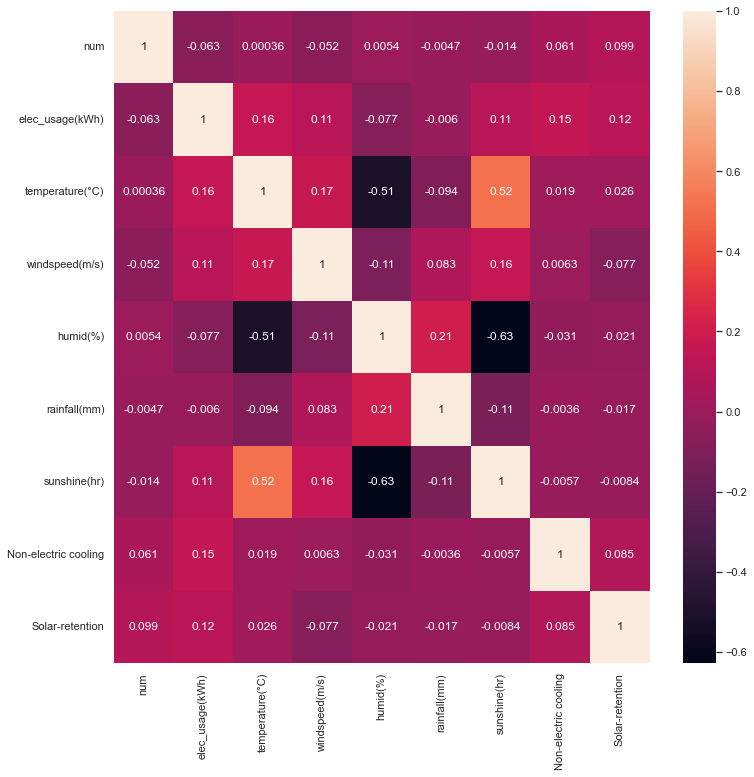

In [27]:
sns.set(style="white")

f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cor, annot=True)

In [28]:
train_date = train.copy()
train_date

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [33]:
train_date['date_time']=pd.to_datetime(train_date['date_time'])
train_date['date_time']

0        2020-06-01 00:00:00
1        2020-06-01 01:00:00
2        2020-06-01 02:00:00
3        2020-06-01 03:00:00
4        2020-06-01 04:00:00
                 ...        
122395   2020-08-24 19:00:00
122396   2020-08-24 20:00:00
122397   2020-08-24 21:00:00
122398   2020-08-24 22:00:00
122399   2020-08-24 23:00:00
Name: date_time, Length: 122400, dtype: datetime64[ns]

In [34]:
train_date['date_time'].dtype

dtype('<M8[ns]')

In [35]:
train_date

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [40]:
train_date['dayofweek']=train_date['date_time'].dt.dayofweek

In [41]:
train_date

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,dayofweek
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,0
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,0
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,0
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,0


In [43]:
train_date.insert(2,'dayofweek_1',train_date['dayofweek'])

In [45]:
train_date

,num,date_time,dayofweek_1,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,dayofweek
0,1,2020-06-01 00:00:00,0,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0
1,1,2020-06-01 01:00:00,0,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,0
2,1,2020-06-01 02:00:00,0,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,0
3,1,2020-06-01 03:00:00,0,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,0
4,1,2020-06-01 04:00:00,0,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
122394,60,2020-08-24 18:00:00,0,4189.104,28.5,2.2,66.0,0.0,1.0,1.0,1.0,0
122395,60,2020-08-24 19:00:00,0,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,0
122396,60,2020-08-24 20:00:00,0,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,0
122397,60,2020-08-24 21:00:00,0,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,0


In [46]:
train_date = train_date.drop('dayofweek', 1)

C:\Users\USER\AppData\Local\Temp\ipykernel_11640\790988430.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_date = train_date.drop('dayofweek', 1)


In [47]:
train_date

,num,date_time,dayofweek_1,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00:00:00,0,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01:00:00,0,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02:00:00,0,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03:00:00,0,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04:00:00,0,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,0,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20:00:00,0,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21:00:00,0,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22:00:00,0,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [50]:
train_date=train_date.rename(columns={'dayofweek_1':'dayofweek'})

In [51]:
train_date

,num,date_time,dayofweek,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00:00:00,0,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01:00:00,0,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02:00:00,0,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03:00:00,0,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04:00:00,0,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,0,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20:00:00,0,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21:00:00,0,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22:00:00,0,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [53]:
train_date.to_csv('train_date.csv')

# minmax

In [55]:
MMscaler = MinMaxScaler()

In [69]:
np.unique(train_date['dayofweek'])

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [70]:
train_date[['dayofweek', '전력사용량(kWh)', '기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm)']]

,dayofweek,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm)
0,0,8179.056,17.6,2.5,92.0,0.8
1,0,8135.640,17.7,2.9,91.0,0.3
2,0,8107.128,17.5,3.2,91.0,0.0
3,0,8048.808,17.1,3.2,91.0,0.0
4,0,8043.624,17.0,3.3,92.0,0.0
...,...,...,...,...,...,...
122395,0,4114.368,27.8,2.3,68.0,0.0
122396,0,3975.696,27.3,1.2,71.0,0.0
122397,0,3572.208,27.3,1.8,71.0,0.0
122398,0,3299.184,27.1,1.8,74.0,0.0


In [72]:
train_MM=train_date.copy()
train_MM

,num,date_time,dayofweek,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00:00:00,0,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01:00:00,0,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02:00:00,0,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03:00:00,0,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04:00:00,0,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,0,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20:00:00,0,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21:00:00,0,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22:00:00,0,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [73]:
MMscaler.fit(train_MM[['dayofweek', '전력사용량(kWh)', '기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm)']])

MinMaxScaler()

In [75]:
train_MM[['dayofweek', '전력사용량(kWh)', '기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm)']]=\
MMscaler.transform(train_MM[['dayofweek', '전력사용량(kWh)', '기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm)']])

In [76]:
train_MM

,num,date_time,dayofweek,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00:00:00,0.0,0.461072,0.257937,0.124378,0.901235,0.009816,0.0,0.0,0.0
1,1,2020-06-01 01:00:00,0.0,0.458624,0.261905,0.144279,0.888889,0.003681,0.0,0.0,0.0
2,1,2020-06-01 02:00:00,0.0,0.457017,0.253968,0.159204,0.888889,0.000000,0.0,0.0,0.0
3,1,2020-06-01 03:00:00,0.0,0.453729,0.238095,0.159204,0.888889,0.000000,0.0,0.0,0.0
4,1,2020-06-01 04:00:00,0.0,0.453437,0.234127,0.164179,0.901235,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,0.0,0.231936,0.662698,0.114428,0.604938,0.000000,0.7,1.0,1.0
122396,60,2020-08-24 20:00:00,0.0,0.224119,0.642857,0.059701,0.641975,0.000000,0.0,1.0,1.0
122397,60,2020-08-24 21:00:00,0.0,0.201373,0.642857,0.089552,0.641975,0.000000,0.0,1.0,1.0
122398,60,2020-08-24 22:00:00,0.0,0.185982,0.634921,0.089552,0.679012,0.000000,0.0,1.0,1.0


In [77]:
train_MM.to_csv('train_MM.csv')

In [78]:
np.unique(train_MM['dayofweek'])

array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 1.        ])

In [79]:
min(train_MM['date_time'])

Timestamp('2020-06-01 00:00:00')

In [80]:
max(train_MM['date_time'])

Timestamp('2020-08-24 23:00:00')

# -----------------------------------------------------------------------------------

In [81]:
train_date

,num,date_time,dayofweek,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00:00:00,0,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01:00:00,0,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02:00:00,0,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03:00:00,0,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04:00:00,0,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,0,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20:00:00,0,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21:00:00,0,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22:00:00,0,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [84]:
train_date['dayofweek'].dtype

dtype('int64')

In [ ]:
# df['log_date']=df['dt2'].dt.date

In [109]:
train_date['date_time'].dt.date

0         2020-06-01
1         2020-06-01
2         2020-06-01
3         2020-06-01
4         2020-06-01
             ...    
122395    2020-08-24
122396    2020-08-24
122397    2020-08-24
122398    2020-08-24
122399    2020-08-24
Name: date_time, Length: 122400, dtype: object

In [131]:
train_date['date_time'].dt.date

0         2020-06-01
1         2020-06-01
2         2020-06-01
3         2020-06-01
4         2020-06-01
             ...    
122395    2020-08-24
122396    2020-08-24
122397    2020-08-24
122398    2020-08-24
122399    2020-08-24
Name: date_time, Length: 122400, dtype: object

In [135]:
sum(train_date['date_time'].dt.date=='2020-06-06')

0

In [133]:
train_date[train_date['date_time'].dt.date=='2020-06-06']

,num,date_time,dayofweek,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유


In [108]:
[train_date['date_time'].dt.date==pytimekr.holidays(2020)]

ValueError: ('Lengths must match to compare', (122400,), (15,))

In [102]:
train_date['date_time']

AttributeError: 'Series' object has no attribute 'date'

In [126]:
train_date['date_time'].date

AttributeError: 'Series' object has no attribute 'date'

In [99]:
train_date[(train_date['dayofweek']==5) | (train_date['dayofweek']==6) | (train_date['date_time']==pytimekr.holidays(2020))]

ValueError: ('Lengths must match to compare', (122400,), (15,))

In [96]:
# 6.6 , 8.15 , 8.17 
list=pytimekr.holidays(2020)
list

[datetime.date(2020, 1, 24),
 datetime.date(2020, 1, 25),
 datetime.date(2020, 1, 26),
 datetime.date(2020, 9, 30),
 datetime.date(2020, 10, 1),
 datetime.date(2020, 10, 2),
 datetime.date(2020, 1, 1),
 datetime.date(2020, 3, 1),
 datetime.date(2020, 5, 5),
 datetime.date(2020, 4, 30),
 datetime.date(2020, 6, 6),
 datetime.date(2020, 8, 15),
 datetime.date(2020, 10, 9),
 datetime.date(2020, 10, 3),
 datetime.date(2020, 12, 25)]